In [3]:
import gc
import torch
import os
import shutil
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
from sklearn.model_selection import train_test_split
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Device set to GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Device set to CPU.")

CUDA is available. Device set to GPU.


In [4]:
!unzip /content/compds.csv.zip

Archive:  /content/compds.csv.zip
  inflating: train.csv               


In [1]:
!pip install transformers[torch] accelerate -U

In [4]:
df = pd.read_csv('/content/train.csv')
df = df.head(30)

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
models = [
    'microsoft/deberta-base',
    'microsoft/deberta-large',
    'microsoft/deberta-v3-large',
    'allenai/longformer-base-4096',
    'google/bigbird-roberta-base',
    'google/bigbird-roberta-large',
]

In [6]:
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

class EssayDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, text_col='full_text', label_col='score'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        essay = str(self.data.iloc[index][self.text_col])
        score = self.data.iloc[index][self.label_col]

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(score, dtype=torch.long)
        }

def train_model(model_name, train_df, val_df):
    try:
        print(f"Training {model_name}...")
        clear_memory()

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

        # Create datasets
        train_dataset = EssayDataset(train_df, tokenizer, max_len=512, text_col='full_text', label_col='score')
        val_dataset = EssayDataset(val_df, tokenizer, max_len=512, text_col='full_text', label_col='score')

        # Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=6,  # 6 possible scores
            trust_remote_code=True
        )
        output_dir = f'./finetuned_models/finetuned_{model_name.replace("/", "_")}'

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=8,
            per_device_train_batch_size=12,  # Reduced batch size
            per_device_eval_batch_size=24,   # Reduced batch size
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir=f'{output_dir}/logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            fp16=True,  # Enable mixed precision training
            gradient_accumulation_steps=8,  # Gradient accumulation
            learning_rate=5e-5,  # Adjust as needed
        )

        # Create Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        # Train the model
        trainer.train()

        # Save the model and tokenizer
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

        # Optionally, remove intermediate files
        # clear_intermediate_files(output_dir)  # This line is commented out

        print(f'Finished training {model_name}\n')
    except RuntimeError as e:
        print(f"Error training {model_name}: {e}")
        clear_memory()

for model_name in models:
    train_model(model_name, train_df, val_df)

Training microsoft/deberta-base...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.858495
2,No log,1.858410


Finished training microsoft/deberta-base

Training microsoft/deberta-large...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.779236
2,No log,1.778761


Finished training microsoft/deberta-large

Training microsoft/deberta-v3-large...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.841291
2,No log,1.840960


Finished training microsoft/deberta-v3-large

Training allenai/longformer-base-4096...


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Initializing global attention on CLS token...


Epoch,Training Loss,Validation Loss
1,No log,1.934733
2,No log,1.934733


Finished training allenai/longformer-base-4096

Training google/bigbird-roberta-base...


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch,Training Loss,Validation Loss
1,No log,1.920085
2,No log,1.919271


Finished training google/bigbird-roberta-base

Training google/bigbird-roberta-large...


tokenizer_config.json:   0%|          | 0.00/969 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch,Training Loss,Validation Loss
1,No log,1.865560
2,No log,1.863770


Finished training google/bigbird-roberta-large



In [ ]:
importpandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
lasso_importance = pd.read_csv('/content/lasso_feature_importance.csv')
rf_importance = pd.read_csv('/content/rf_feature_importance (1).csv')


In [9]:
lasso_importance.columns = ['feautures','importances']
rf_importance.columns = ['feautures','importances']

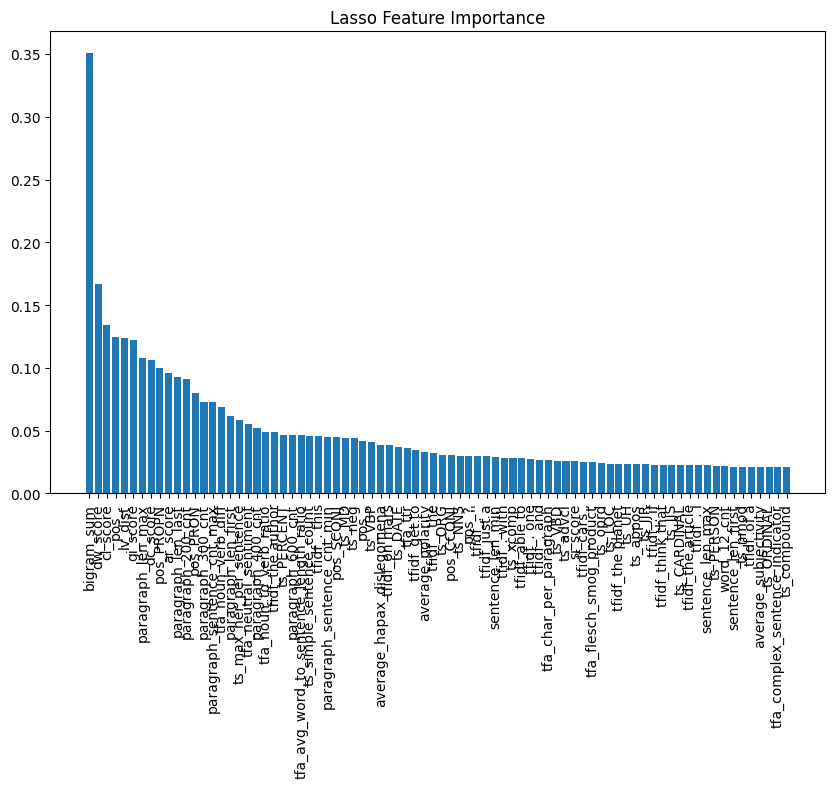

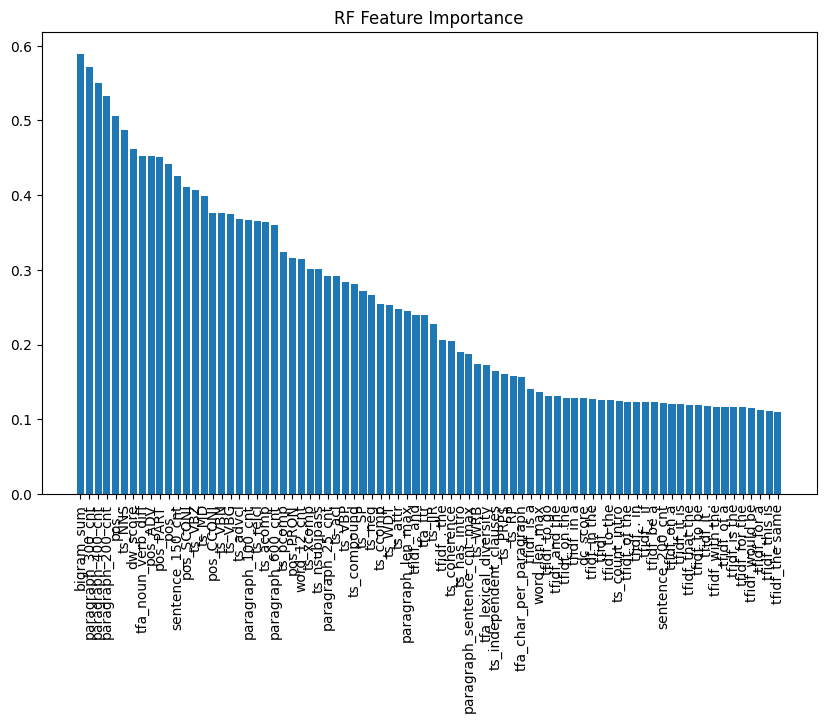

In [12]:
# prompt: Build bar graphs with lasso importances and rf importance, Features as x axis as categorical and importances as y.  As separate graphs and sorted from highest to lowest. Display only the first 80

import matplotlib.pyplot as plt

# Sort dataframes by importance in descending order
lasso_importance = lasso_importance.sort_values(by='importances', ascending=False).head(80)
rf_importance = rf_importance.sort_values(by='importances', ascending=False).head(80)

# Create separate bar graphs
plt.figure(figsize=(10, 6))
plt.bar(lasso_importance['feautures'], lasso_importance['importances'])
plt.xticks(rotation=90)
plt.title('Lasso Feature Importance')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(rf_importance['feautures'], rf_importance['importances'])
plt.xticks(rotation=90)
plt.title('RF Feature Importance')
plt.show()


In [13]:
# prompt: output the first 100 features with the highest importance from both files. I mean 100  from each and then combine both and remove duplicates

# Read the feature importance files
lasso_importance = pd.read_csv('/content/lasso_feature_importance.csv')
rf_importance = pd.read_csv('/content/rf_feature_importance (1).csv')

# Rename columns for consistency
lasso_importance.columns = ['features', 'lasso_importance']
rf_importance.columns = ['features', 'rf_importance']

# Sort dataframes by importance in descending order and select top 100 features
lasso_top_100 = lasso_importance.sort_values(by='lasso_importance', ascending=False).head(100)
rf_top_100 = rf_importance.sort_values(by='rf_importance', ascending=False).head(100)

# Combine both lists and remove duplicates
combined_features = pd.concat([lasso_top_100['features'], rf_top_100['features']]).drop_duplicates()

# Print the first 100 features with the highest importance
print(combined_features.head(100))


0          bigram_sum
1            dw_score
2            cl_score
3               pos_.
4             lv_dist
           ...       
95     tfidf_the time
96           ts_csubj
97       tfidf_way to
98       word_len_std
99    tfidf_the first
Name: features, Length: 100, dtype: object


In [15]:
combined_features.to_csv('combined_features.csv')